#Suggerimenti da implementare:


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
# Per unire una serie di operazini in unico oggetto
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Import Dataset

In [8]:
testing = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv")
training = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv")

In [9]:
#remove records with no labels
training.dropna(axis = 0 , subset=["Survived"],inplace=True)
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [10]:
#visualization of missing values
null_counter = [(col, training[col].isnull().sum(),training[col].isnull().sum()/len(training) ) for col in training.columns if training[col].isnull().sum() > 0 ]
null_counter = pd.DataFrame(null_counter,columns=["Feature","Missings","%"] )
null_counter

,Feature,Missings,%
0,Age,177,0.198653
1,Cabin,687,0.771044
2,Embarked,2,0.002245


In [10]:
X = training.drop("Survived", axis = 1)
y = training.Survived

In [11]:
numerical_features = ["Age","SibSp","Parch","Fare"]
categorical_features = ["Pclass","Sex","Ticket","Cabin","Embarked"]

In [12]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##Data Exploration

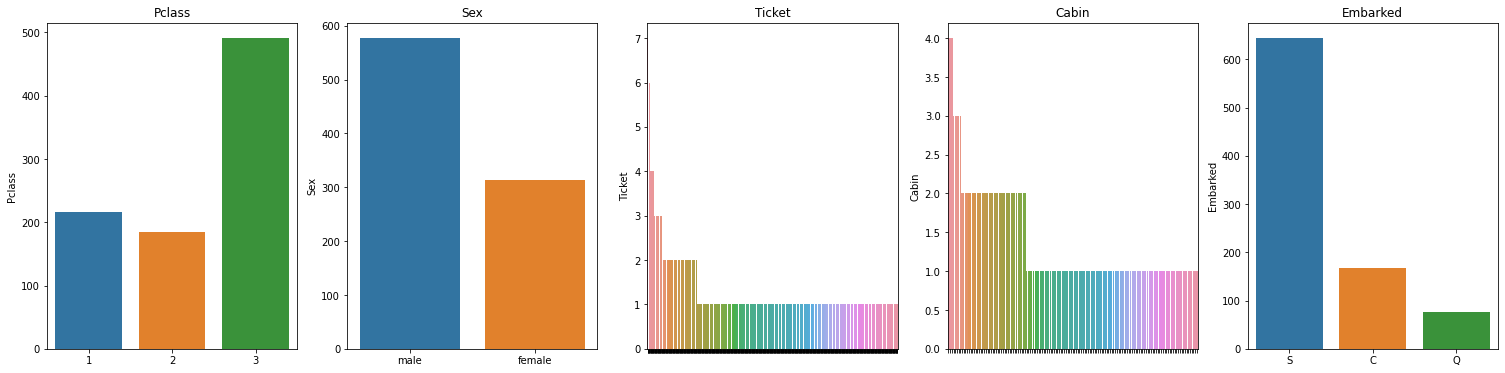

In [14]:
#categorical features
fig=plt.figure(figsize=(26, 6))

for idx,feature in enumerate(categorical_features):
  fig.add_subplot(1, 5, idx+1)
  if idx == 2 or idx == 3:
    sns.barplot(training[feature].value_counts().index,training[feature].value_counts(),).set(xticklabels=[],title = feature) #remove xticks
  else:
    sns.barplot(training[feature].value_counts().index,training[feature].value_counts()).set_title(feature)
plt.show()

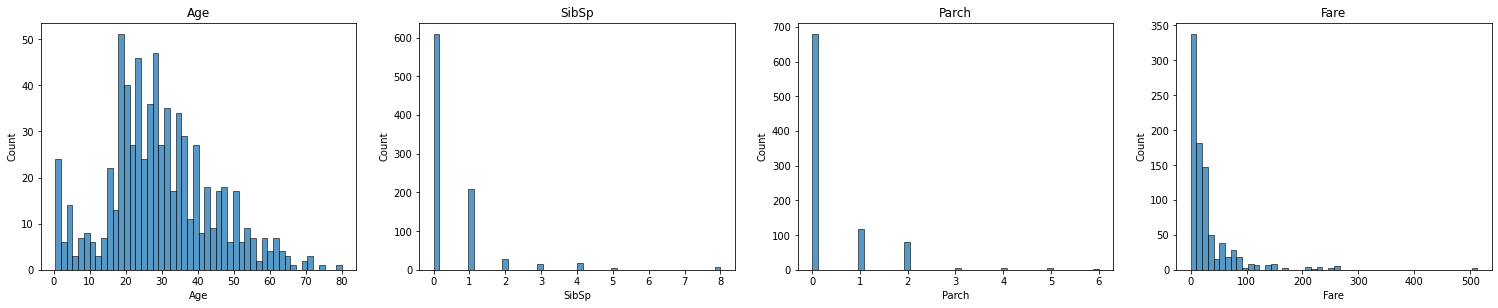

In [15]:
#numerical features
fig=plt.figure(figsize=(26, 10))

for idx,feature in enumerate(numerical_features):
  fig.add_subplot(2, 4, idx+1)
  sns.histplot(training[feature], bins = 50).set_title(feature)
plt.show()

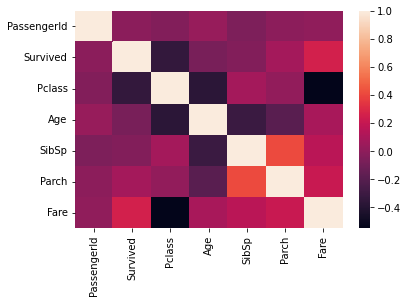

In [16]:
#visualize correlation
sns.heatmap(training.corr())

### Questions:

1.   Man survive more likely than women ?
2.   The Pclass is meaningful to survive ? 
3.   The Embark is meaningful to survive ? 



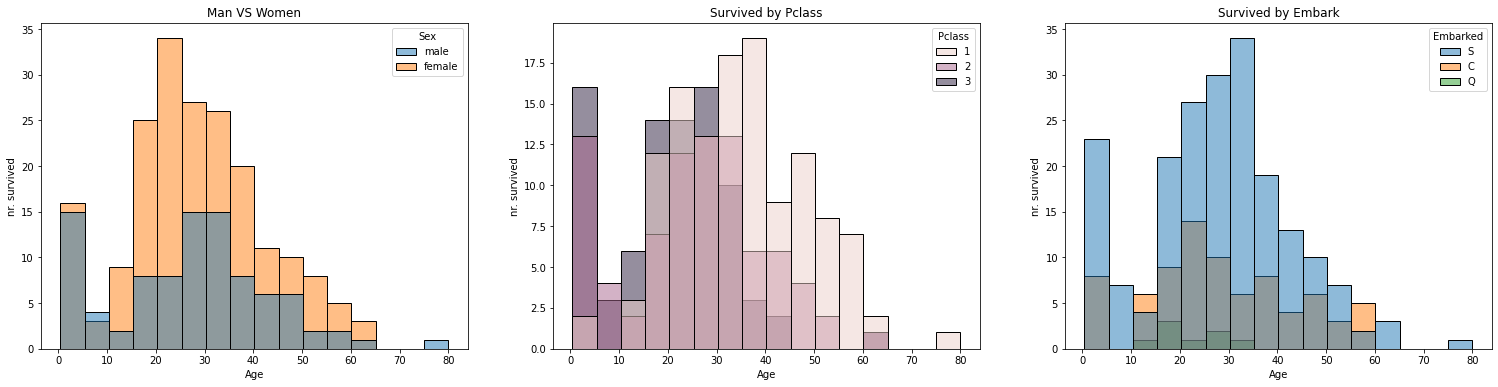

In [17]:
fig=plt.figure(figsize=(26, 6))

fig.add_subplot(1, 3, 1)
sns.histplot(data=training,x=training.Age[training.Survived == 1 ],hue="Sex").set_title("Man VS Women")
plt.ylabel("nr. survived")

fig.add_subplot(1, 3, 2)
sns.histplot(data=training,x=training.Age[training.Survived == 1],hue="Pclass").set_title("Survived by Pclass")
plt.ylabel("nr. survived")

fig.add_subplot(1, 3, 3)
sns.histplot(data=training,x=training.Age[training.Survived == 1],hue="Embarked").set_title("Survived by Embark")
plt.ylabel("nr. survived")

plt.show()

##Feature Engineering

Adding new features


*   Number of relatives = number of sibilings + parents/cildren
*   Get title Mr,Mss, Lord etc.. from name



In [55]:
#create a copy, dont mess with original dafaFrame
X_c = X.copy()

In [22]:
X_c["n_relatives"] = X_c.Parch + X_c.SibSp
X_c["n_relatives"] = X_c.Parch + X_c.SibSp

#drop useless features
#X.drop(["Parch","SibSp"],axis = 1, inplace = True)

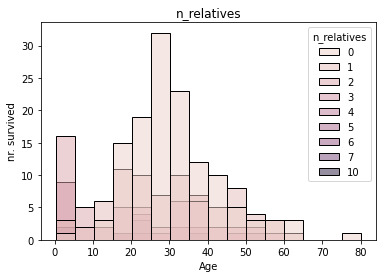

In [23]:
sns.histplot(data=training,x=training.Age[training.Survived == 1 ],hue=X_c.n_relatives).set_title("n_relatives")
plt.ylabel("nr. survived")
plt.show()

In [24]:
X_c["Title"] = X_c.Name.apply(lambda x : x.replace(",","").replace(".","").split()[1]);
#X.drop("Name",axis = 1, inplace = True)

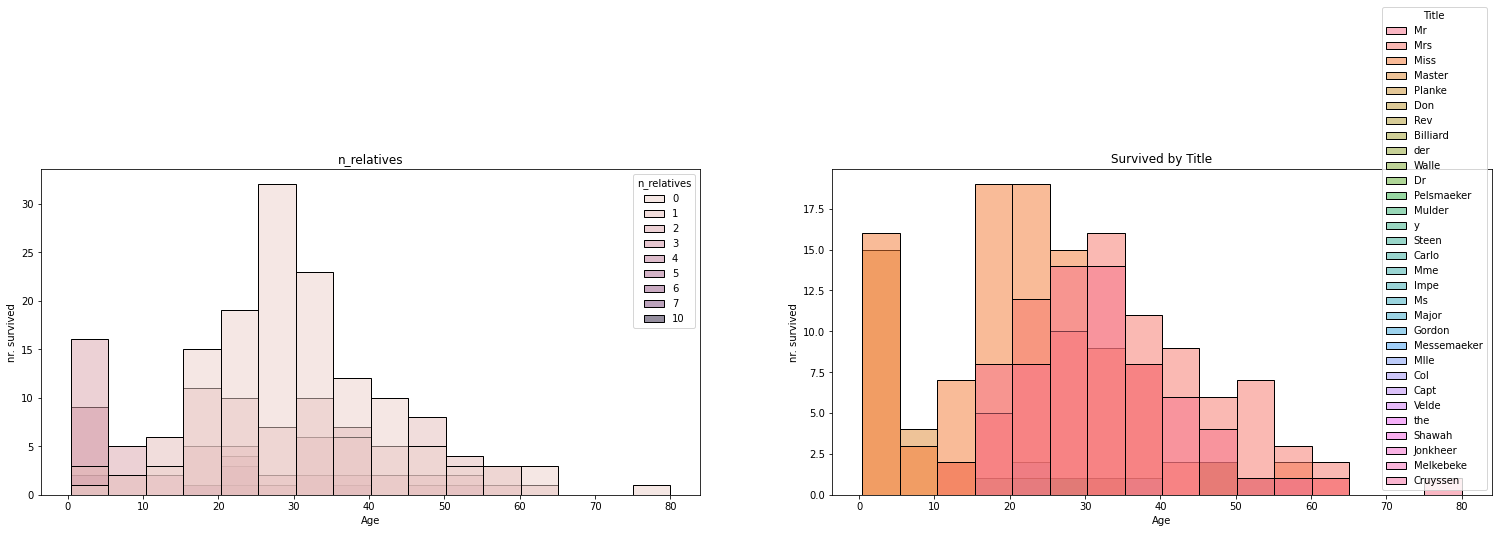

In [25]:
fig=plt.figure(figsize=(26, 6))

fig.add_subplot(1, 2, 1)
sns.histplot(data=training,x=training.Age[training.Survived == 1 ],hue=X_c.n_relatives).set_title("n_relatives")
plt.ylabel("nr. survived")

fig.add_subplot(1, 2, 2)
sns.histplot(data=training,x=training.Age[training.Survived == 1],hue=X_c.Title).set_title("Survived by Title")
plt.ylabel("nr. survived")

plt.show()

##Combine features automatically
create a Trasformer class to apply feature engineering



In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

#need index beacuse we use numpy araays 
X_list = X.columns.tolist()
sibSp_idx = X_list.index("SibSp")
parch_idx  = X_list.index("Parch")
age_idx = X_list.index("Age")
name_idx = X_list.index("Name")

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self,add_age_bins = True):
    self.add_age_bins = add_age_bins

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    #n_relatives feature
    n_relatives = X[:,sibSp_idx] + X[:,parch_idx]
    
    #title feature
    get_title = lambda x : x.replace(",","").replace(".","").split()[1]
    vfunc = np.vectorize(get_title)
    title = vfunc(X[:,name_idx])

    #if you also wanto to add age_bins feature
    if self.add_age_bins:
      age = X[:,age_idx]
      bins = np.arange(0,100,10)
      inds = np.digitize(age, bins)
      age_bins = [bins[i-1] for i in inds]

      return np.c_[X, n_relatives, title, age_bins]
    return np.c_[X, n_relatives, title]

In [14]:
#use custom trasformer
attr_adder = CombinedAttributesAdder(add_age_bins=True)
train_extra_attr = attr_adder.transform(X.values)

#convert to DataFrame again
cols = X.columns.to_list()
cols.extend(["n_relatives","title","age_bins"])
X = pd.DataFrame(train_extra_attr,columns = cols)

In [15]:
#lets see the new dataset
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_relatives,title,age_bins
0,1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S,1,Mr,20
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,Mrs,30
2,3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NaN,S,0,Miss,20
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,1,Mrs,30
4,5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NaN,S,0,Mr,30


#Imputation and Encode

1.   knn imputer for "Age"
2.   iterative imputer for "Cabin"
3.   Target Encoder for categorical
4.   Embarked with most frequent values





In [ ]:
!pip install category_encoders

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [32]:
num_pipeline = Pipeline(steps = [
  ("imputer", SimpleImputer(strategy = "median")),
  ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps = [
  ("cat_imputer",SimpleImputer(strategy = "most_frequent")),
  ("ohe",OneHotEncoder(handle_unknown= "ignore"))
])

preprocess = ColumnTransformer([
  ("num",num_pipeline, numerical_features),
  ("cat",cat_pipeline, categorical_features)                                     
])

#Try different models

In [33]:
 rfc = RandomForestClassifier()
 lr = LogisticRegression()
 sv =svm.SVC()

 models = [rfc,lr,sv]

#Evaluation using KFold

In [38]:
from sklearn.model_selection import cross_validate

X_preprocessed = preprocess.fit_transform(X)

for model in models:
  scores = cross_validate(model, X_preprocessed,y ,scoring = "accuracy",cv = 5, return_train_score=True)
  print("model" , model)
  print(np.mean(scores["train_score"]), np.mean(scores["test_score"])); print()

model RandomForestClassifier()
0.9983161826118474 0.8383654510074697

model LogisticRegression()
0.8908544368627573 0.8204067541271733

model SVC()
0.8473643569661344 0.827154604230745



#Model Selection with RadomizedSearch
###Lets search on RandomForest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = [
  {"n_estimators" :[200,250,260,270,280], "max_features": [2,4,6,8,18,28,38,48,58,68]},
  {"n_estimators" :[100,150,200], "max_features" : [ 10 , 30, 50, 70] , "max_depth" : [4, 5, 6]}
  {"n_estimators" :[200,250,260,270,280], "max_features": [2,4,6,8,18,28,]},

]

rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, param_grid, cv = 4, scoring = "accuracy", return_train_score= True)

X_preprocessed = preprocess.fit_transform(X)
grid_search.fit(X_preprocessed,y)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8, 18, 28, 38, 48, 58, 68],
                          'n_estimators': [200, 250, 260, 270, 280]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
#print the obtained scores
curves = grid_search.cv_results_
for mean_score, params in zip(curves["mean_test_score"],curves["params"]):
  print(mean_score,params)

0.8294146164101321 {'max_features': 2, 'n_estimators': 200}
0.8406405284207975 {'max_features': 2, 'n_estimators': 250}
0.8406304286349129 {'max_features': 2, 'n_estimators': 260}
0.8361511735951197 {'max_features': 2, 'n_estimators': 270}
0.8249252615844545 {'max_features': 2, 'n_estimators': 280}
0.8316517189835576 {'max_features': 4, 'n_estimators': 200}
0.8361562234880621 {'max_features': 4, 'n_estimators': 250}
0.835030097361936 {'max_features': 4, 'n_estimators': 260}
0.8372722498283036 {'max_features': 4, 'n_estimators': 270}
0.830535692643316 {'max_features': 4, 'n_estimators': 280}
0.8372671999353614 {'max_features': 6, 'n_estimators': 200}
0.8327828950026259 {'max_features': 6, 'n_estimators': 250}
0.8316567688764998 {'max_features': 6, 'n_estimators': 260}
0.8316668686623843 {'max_features': 6, 'n_estimators': 270}
0.829414616410132 {'max_features': 6, 'n_estimators': 280}
0.8294196663030744 {'max_features': 8, 'n_estimators': 200}
0.8462408596937745 {'max_features': 8, 'n_e

In [ ]:
rfc_best_params = grid_search.best_params_
rfc_best_params

{'max_features': 8, 'n_estimators': 250}

In [ ]:
rfc_random_search = RandomForestClassifier(**rfc_best_params)
rfc_random_search

RandomForestClassifier(max_features=8, n_estimators=250)

#Model Selection with Optuna
##Lets search on RandomForest


In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error, make_scorer

In [ ]:
model = RandomForestClassifier()

In [ ]:
class Objective_function:
  def __init__(self, model, preprocessor,X_train, y_train):
    self.model = model
    self.preprocessor = preprocessor
    self.X = X
    self.y = y
    self.train_scores = []

  def __call__(self, trial):
    #selezione degli iperparametri
    params = dict( 
      n_estimators = trial.suggest_int("rf_n_estimators", 25, 400, log = True) ,#andiamo logaritmici dal 100
      min_samples_split = trial.suggest_int("rf_min_sample_split", 2, 10),
      max_features = trial.suggest_categorical("rf_max_feature", ["auto","sqrt","log2"]) 
    )

    #creazione
    self.model.set_params(**params)

    #USIAMO CROSS VALIDATE
    scores = cross_validate(self.model,
                    X = self.preprocessor.fit_transform(self.X),
                    y = self.y,
                    scoring = "accuracy", 
                    cv = 5,
                    return_train_score=True,
                    error_score="raise"
                  )
    self.train_scores.append(np.mean(scores["test_score"]))

    return np.mean(scores["test_score"])

In [ ]:
study = optuna.create_study(storage = "sqlite:///model_selection.db" ,study_name="random_forest_classifier", direction = "maximize", load_if_exists=True)

[I 2021-12-22 10:36:25,511] Using an existing study with name 'random_forest_classifier' instead of creating a new one.


In [ ]:
obj_func_with_categorical = Objective_function(model,preprocess, X, y)

In [ ]:
study.optimize(func = obj_func_with_categorical, n_trials = 100)

In [ ]:
study.best_params

{'rf_max_feature': 'log2', 'rf_min_sample_split': 9, 'rf_n_estimators': 64}

In [ ]:
rfc_optuna = RandomForestClassifier(max_features="log2",min_samples_split=9, n_estimators=64)

#Make prediction with both models found with randomSearch and Optuna

###Preprocess test data


In [ ]:
#fit
X_preprocessed = preprocess.fit_transform(X)
rfc_optuna.fit(X_preprocessed,y)
rfc_random_search.fit(X_preprocessed,y)

RandomForestClassifier(max_features=8, n_estimators=250)

In [ ]:
#use custom trasformer
attr_adder_test = CombinedAttributesAdder(add_age_bins=True)
test_extra_attr = attr_adder_test.fit_transform(data_testing.values)

#convert to DataFrame again
cols = data_testing.columns.to_list()
cols.extend(["n_relatives","title","age_bins"])
data_testing = pd.DataFrame(test_extra_attr,columns = cols)

#preprocess test data
data_testing_preprocessed = preprocess.transform(data_testing)

In [ ]:
#predict
random_search_preds = rfc_random_search.predict(data_testing_preprocessed)
optuna_preds = rfc_optuna.predict(data_testing_preprocessed)

#Crate output File

In [ ]:
output = pd.DataFrame({'PassengerId': np.arange(892,1310), 'Survived': random_search_preds})
output.to_csv('random_search_preds.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
output = pd.DataFrame({'PassengerId': np.arange(892,1310), 'Survived': optuna_preds})
output.to_csv('optuna_preds.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
